In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import re

import nltk as nlp # Main Library for NLP
from nltk.corpus import stopwords # stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB #MultinomialNB # for the model - also try Guassian

import nltk, re, string, collections
from nltk.util import ngrams
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fake-and-real-news-dataset/True.csv
/kaggle/input/fake-and-real-news-dataset/Fake.csv


# 1. EDA and Data Preprocessing

In [2]:
fake = pd.read_csv("../input/fake-and-real-news-dataset/Fake.csv")
real = pd.read_csv("../input/fake-and-real-news-dataset/True.csv")

In [3]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [4]:
real.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
fake.shape,real.shape
#if i conacatenate these you want the rows to be (23481+21417=44898)

((23481, 4), (21417, 4))

In [6]:
fake.info()
real.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [7]:
#adding classifier as a number: 1 if the article is fake, 0 otherwise
fake['class'] = 1
real['class'] = 0

all_data = pd.concat([fake,real])
all_data.head()

,title,text,subject,date,class
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",1


In [8]:
all_data.shape

(44898, 5)

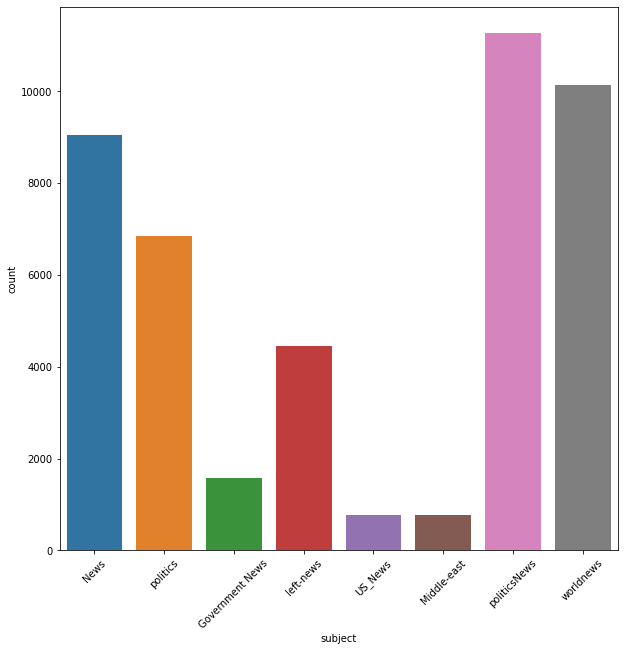

In [9]:
fig, ax = plt.subplots(figsize=(10,10))
plt.xticks(rotation=45)
ax = sns.countplot(x = all_data.subject)

In [10]:
all_data = all_data.drop(['title','date','subject'], axis=1)
all_data.head()

,text,class
0,Donald Trump just couldn t wish all Americans ...,1
1,House Intelligence Committee Chairman Devin Nu...,1
2,"On Friday, it was revealed that former Milwauk...",1
3,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis used his annual Christmas Day mes...,1


In [11]:
all_data = all_data.sample(frac = 1) #Shuffling our data
all_data.head()

,text,class
14150,MOSCOW (Reuters) - U.N. special envoy on Syria...,0
9675,The View s Joy Behar was beaming after watchin...,1
829,WASHINGTON (Reuters) - A foreign policy advise...,0
606,Walmart s back to school advertising took a pr...,1
6156,WASHINGTON (Reuters) - The new U.S. administra...,0


Lets process our text!

# 2. Text Preprocessing

In [12]:
nlp.download("stopwords") 
lemma=nlp.WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [13]:
 def text_process(data):
    text_list=[]
    for text in data.text:
        text=re.sub("[^a-zA-Z]"," ",text) # extracting unnecesary characters
        text=text.lower() #makes characters lowercase
        text=nlp.word_tokenize(text) # splits all the words
        text=[word for word in text if not word in set(stopwords.words("english"))] # extract stopwords
        text=[lemma.lemmatize(word) for word in text] # Lemmatisation
        text=" ".join(text) 
        text_list.append(text)
        
    return text_list

**You will see me take sample sizes for my datasets - this is because my computer is not powerful enough to do this for the full datasets**

In [14]:
fake_sample = fake.sample(n=1000) #10,000
fake_text = text_process(fake_sample)

In [15]:
text_all = ''
for text in fake_text:    
    text_all = text_all + " " + text

    
bigrm = list(nltk.bigrams(text_all.split()))
BigramFreq = collections.Counter(bigrm)
BigramFreq = BigramFreq.most_common(10)
print(BigramFreq)

[(('donald', 'trump'), 543), (('featured', 'image'), 316), (('white', 'house'), 269), (('united', 'state'), 269), (('hillary', 'clinton'), 255), (('image', 'via'), 244), (('twitter', 'com'), 215), (('pic', 'twitter'), 206), (('new', 'york'), 189), (('president', 'trump'), 184)]


<AxesSubplot:>

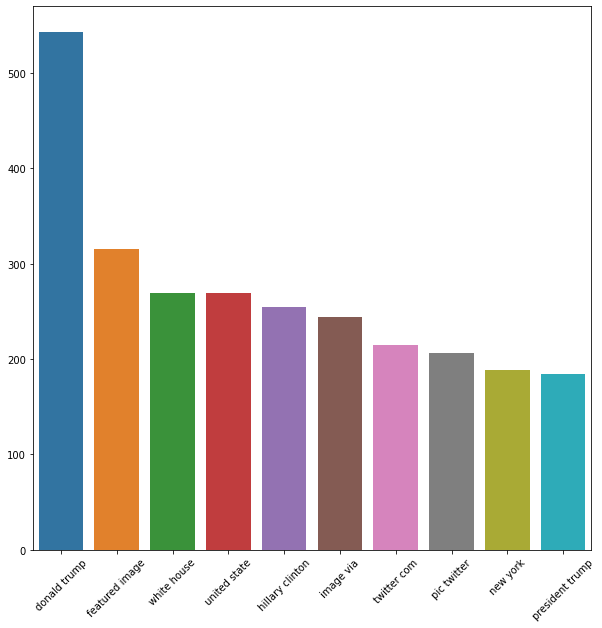

In [16]:
bigrams = [x[0] for x in BigramFreq]
count = [x[1] for x in BigramFreq]

for i in range(len(bigrams)):
    bigrams[i] = bigrams[i][0] + " " + bigrams[i][1]

    
f, ax = plt.subplots(figsize=(10,10))
plt.xticks(rotation=45)
sns.barplot(x=bigrams,y=count)

Now lets do this for the real articles

In [17]:
real_sample = real.sample(n=1000) #10,000
real_text = text_process(real_sample)

In [18]:
text_all_2 = ''
for text in real_text:    
    text_all_2 = text_all_2 + " " + text

    
bigrm2 = list(nltk.bigrams(text_all_2.split()))
BigramFreq2 = collections.Counter(bigrm2)
BigramFreq2 = BigramFreq2.most_common(10)
print(BigramFreq2)

[(('united', 'state'), 638), (('donald', 'trump'), 498), (('white', 'house'), 370), (('north', 'korea'), 331), (('washington', 'reuters'), 316), (('president', 'donald'), 281), (('new', 'york'), 241), (('prime', 'minister'), 207), (('said', 'statement'), 200), (('u', 'president'), 179)]


<AxesSubplot:>

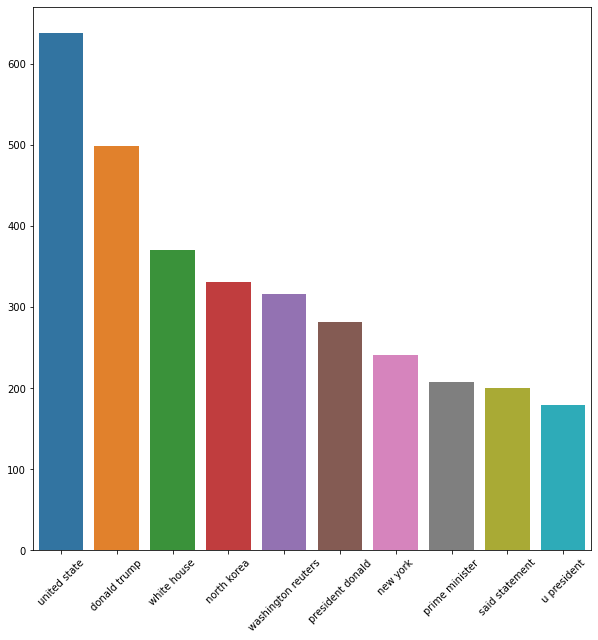

In [19]:
bigrams2 = [x[0] for x in BigramFreq2]
count2 = [x[1] for x in BigramFreq2]

for i in range(len(bigrams2)):
    bigrams2[i] = bigrams2[i][0] + " " + bigrams2[i][1]

    
f, ax = plt.subplots(figsize=(10,10))
plt.xticks(rotation=45)
sns.barplot(x=bigrams2,y=count2)

# 3. Modelling

**I am going to be using a multinomial naive bayes classifier. You could do this with a Gaussian naive bayes classifier as well - however multinomial is better for classifying between two distinct classes - in our case this is Real and Fake news.**

In [20]:
all_data_sample = all_data.sample(n=1000) #10,000
all_data_processed = text_process(all_data_sample)

In [21]:
max_features=1000
count_vectorizer=CountVectorizer(max_features=max_features,stop_words="english")
sparce_matrix=count_vectorizer.fit_transform(all_data_processed).toarray()

In [22]:
print(sparce_matrix)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 1 ... 0 0 0]]


In [23]:
y=all_data_sample.iloc[: , -1]
x=sparce_matrix

In [24]:
print(y)

14009    1
23223    1
3967     0
9359     0
22631    1
        ..
10188    0
10721    1
20669    0
12347    1
19053    1
Name: class, Length: 1000, dtype: int64


In [25]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.1,random_state=5)

In [26]:
nb=MultinomialNB()
nb.fit(x_train,y_train)
y_pred= nb.predict(x_test)

In [27]:
y_test = y_test.to_numpy()

In [28]:
print(type(y_test))
print(type(y_pred))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [29]:
print(y_test)
print(y_pred)

[0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 1 0 0 1 0 0 1 0
 1 1 1 0 1 1 1 0 0 1 1 0 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 0 0 1 0 1 0 1 0 1 0
 0 0 1 1 1 0 1 0 0 1 1 1 1 1 0 0 1 1 0 0 0 1 0 1 1 1]
[0 0 1 0 0 1 1 0 0 0 0 0 1 1 0 0 0 1 1 1 0 0 0 0 0 1 0 0 1 0 0 0 1 1 0 1 0
 1 1 1 0 1 1 1 0 0 0 1 0 1 1 1 1 0 1 0 1 1 1 1 1 1 0 0 0 0 0 0 1 0 1 0 1 0
 0 0 1 1 1 0 1 0 1 1 1 1 1 1 0 0 1 1 0 0 0 1 1 1 1 1]


In [30]:
count = 0
for i in range(len(y_pred)):
    if y_test[i] == y_pred[i]:
        count+=1
    
print("Accuracy: " + str((count/len(y_pred))* 100))

Accuracy: 93.0


**Accuracy is 94% for Multinomial Bayes - this accuracy could be increased if we choose a larger sample size.**